<a href="https://colab.research.google.com/github/VKSi/2020_12_GB_RecommendationSystems/blob/main/HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/RecSys/'

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 12.5MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419406 sha256=70782ad3c89bc129999bed2f2dd69f8fc8b590f7fdef87df04e78ac2c27056dc
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


In [ ]:
# Функции из модуля metrics
def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision


def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    

    bought_list = bought_list  # Тут нет [:k] !!
    
    if k < len(recommended_list):
        recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision


def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):
    # your_code
    # Лучше считать через скалярное произведение, а не цикл

    return precision


def recall(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    flags = np.isin(bought_list, recommended_list)

    recall = flags.sum() / len(bought_list)

    return recall


def recall_at_k(recommended_list, bought_list, k=5):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    if k < len(recommended_list):
        recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)
    recall = flags.sum() / len(bought_list)

    return recall


def money_recall_at_k(recommended_list, bought_list, prices_recommended, prices_bought, k=5):
    # your_code

    return recall

In [ ]:
# Функции из модуля utils

def prefilter_items(data, take_n_popular=5000, item_features=None):
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

    top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]

    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]

    # Уберем товары, которые не продавались за последние 12 месяцев

    # Уберем не интересные для рекоммендаций категории (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features.\
                                        groupby('department')['item_id'].nunique().\
                                        sort_values(ascending=False)).reset_index()

        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_rare_departments)]


    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] > 2]

    # Уберем слишком дорогие товарыs
    data = data[data['price'] < 50]

    # Возбмем топ по популярности
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()
    
    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999
    
    # ...

    return data


def postfilter_items(user_id, recommednations):
    pass

In [ ]:
# Функции из модуля recommenders

import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

class MainRecommender:
    """Рекоммендации, которые можно получить из ALS

    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, weighting=True):

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='item_id',
                                          values='quantity',  # Можно пробовать другие варианты
                                          aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads,
                                        use_gpu=False)  # Добавлено, чтобы избежать ошибки с CUDA
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                        user_items=csr_matrix(self.user_item_matrix).tocsr(),
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]],
                                        recalculate_user=True)]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendations(self, user, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_similar_users_recommendations(self, user, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""

        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
        similar_users = [rec[0] for rec in similar_users]
        similar_users = similar_users[1:]   # удалим юзера из запроса

        for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [ ]:
data = pd.read_csv(PATH + 'retail_train.csv')
item_features = pd.read_csv(PATH + 'product.csv')
user_features = pd.read_csv(PATH + 'hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [ ]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [ ]:
recommender = MainRecommender(data_train_lvl_1)

In [ ]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 871756, 1092937, 1106523]

In [ ]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [ ]:
recommender.get_similar_items_recommendations(2375, N=5)

[1046545, 1044078, 1042907, 878285, 15778319]

In [ ]:
recommender.get_similar_users_recommendations(2375, N=5)

[1012801, 9245108, 10457044, 1012801, 820612]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [ ]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [ ]:
k = 50

Напишем полезные функции для автоматизации дальнейшей работы

In [ ]:
def get_bought_list(actual_data, user_id):
  return actual_data.loc[actual_data['user_id'] == user_id, 'actual'].values[0]

def get_recommended_list(func_name: str, user_id, N):
  return eval(f'recommender.get_{func_name}_recommendations({user_id}, {N})')

def total_recall_at_k(actual_data, k, N, func_name: str):
  rc = []
  for uid in set(recommender.id_to_userid.values()):
    if uid not in actual_data['user_id'].values:
      continue
    rl = get_recommended_list(func_name=func_name, user_id=uid, N=N)
    bl = get_bought_list(actual_data=actual_data, user_id=uid)
    rc.append(recall_at_k(rl, bl, k))
  return np.mean(rc), np.std(rc)

In [ ]:
actual_users = set(result_lvl_1)

In [ ]:
actual_users = set(result_lvl_1['user_id'].unique())
len(actual_users)

2154

In [ ]:
predicted_users = set(data_train_lvl_1['user_id'].unique())
len(predicted_users)

2495

In [ ]:
diff = actual_users - predicted_users
diff

{296, 1813, 1984}

In [ ]:
to_count = result_lvl_1['user_id'].isin(predicted_users)

In [ ]:
pu = set(recommender.id_to_userid.values())
len(pu)

2497

In [ ]:
actual_users - pu

{1984}

In [ ]:
print(f'Среднее значение метрики recall_at_k для k = {k}: ')
print(f'Рекомендация \t Среднее значение \t Стандартное отклонени')
for fn in ['als', 'own', 'similar_items']:  # , 'similar_users'
  m, s = total_recall_at_k(actual_data=result_lvl_1[to_count], k=k, N=k, func_name=fn)
  print(f'{fn} \t\t\t {m:.3f} \t\t\t {s:.5f}')

Среднее значение метрики recall_at_k для k = 50: 
Рекомендация 	 Среднее значение 	 Стандартное отклонени
als 			 0.048 			 0.07106
own 			 0.065 			 0.09257
similar_items 			 0.033 			 0.06328


In [ ]:
methods = ['als', 'own', 'similar_items']  # , 'similar_users'
df = pd.DataFrame(columns=methods)
for k in [20, 50, 100, 200]:
  print(f'k: {k}')
  for fn in methods:
    m, s = total_recall_at_k(actual_data=result_lvl_1[to_count], k=k, N=k, func_name=fn)
    df.loc[k, fn] = m
    print(f'\t method: {fn}, metric: {m:.3f}')
  print(df.tail(1))
  print('='*50)
  df.to_csv(PATH + 'total_recall.csv')

k: 20
	 method: als, metric: 0.029
	 method: own, metric: 0.039
	 method: similar_items, metric: 0.018
          als        own similar_items
20  0.0290958  0.0392843     0.0175594
k: 50
	 method: als, metric: 0.048
	 method: own, metric: 0.065
	 method: similar_items, metric: 0.033
          als        own similar_items
50  0.0482734  0.0652566     0.0330639
k: 100
	 method: als, metric: 0.070
	 method: own, metric: 0.096
	 method: similar_items, metric: 0.053
          als        own similar_items
100  0.069917  0.0960449     0.0530717
k: 200
	 method: als, metric: 0.097
	 method: own, metric: 0.135
	 method: similar_items, metric: 0.086
           als       own similar_items
200  0.0973095  0.135373     0.0856481


In [ ]:
df.to_csv(PATH + 'total_recall.csv')
df

,als,own,similar_items
20,0.0290958,0.0392843,0.0175594
50,0.0482734,0.0652566,0.0330639
100,0.069917,0.0960449,0.0530717
200,0.0973095,0.135373,0.0856481


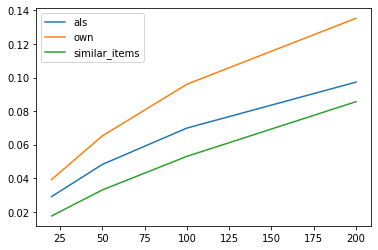

In [ ]:
df.plot()
plt.show()

Видно, что лучше всех показали себя als и own. Модель similar_items на больших k тоже к ним приблизилась.     

Модель similar_users считалась очень долго и я ее выкинул, так как смымл - сосчитать быстро. Если честно, я не понимаю почему модель реализована в таком виде, что берутся 500 юзеров и по каждому отбирается "лучший" товар. Мне кажется, что модель в которой берется 5 ближайших юзеров и отбирается 100 товаров по каждому, показала бы себя лучше. Можно попробовать в курсовике.

Посмотрим, что будет дальше для "выживших" моделей:

In [ ]:
methods = ['als', 'own', 'similar_items']
# df = pd.DataFrame(columns=methods)
for k in [500, 1000, 2000, 5000]:
  print(f'k: {k}')
  for fn in methods:
    m, s = total_recall_at_k(actual_data=result_lvl_1[to_count], k=k, N=k, func_name=fn)
    df.loc[k, fn] = m
    print(f'\t method: {fn}, metric: {m:.3f}')
  print(df.tail(1))
  print('='*50)
  df.to_csv(PATH + 'total_recall_2.csv')

k: 500
	 method: als, metric: 0.146
	 method: own, metric: 0.182
	 method: similar_items, metric: 0.137
          als       own similar_items
500  0.146204  0.182053      0.136558
k: 1000
	 method: als, metric: 0.195
	 method: own, metric: 0.217
	 method: similar_items, metric: 0.182
           als       own similar_items
1000  0.195461  0.216791       0.18203
k: 2000
	 method: als, metric: 0.252
	 method: own, metric: 0.254
	 method: similar_items, metric: 0.233
           als       own similar_items
2000  0.251804  0.254054      0.233097
k: 5000
	 method: als, metric: 0.327
	 method: own, metric: 0.325
	 method: similar_items, metric: 0.324
           als       own similar_items
5000  0.326996  0.325125      0.324268


In [ ]:
df.to_csv(PATH + 'total_recall_2.csv')
df

,als,own,similar_items
20,0.0290958,0.0392843,0.0175594
50,0.0482734,0.0652566,0.0330639
100,0.069917,0.0960449,0.0530717
200,0.0973095,0.135373,0.0856481
500,0.146204,0.182053,0.136558
1000,0.195461,0.216791,0.18203
2000,0.251804,0.254054,0.233097
5000,0.326996,0.325125,0.324268


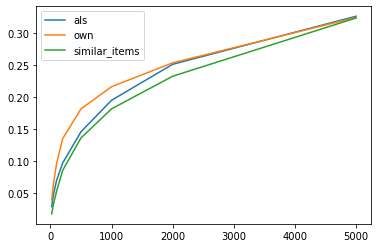

In [ ]:
df.plot()
plt.show()

В конце метрики сравнялись, что и не удивительно: наша префильтрация оставила 5000 товаров.
Судя по графику, разумно остановиться в окрестности 500

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
# Определим функцию для получения рекоммендаций первого уровня из смеси als, own, similar_items и top. Заодно решим проблемму холодного старта

def get_lvl_1_recommendations(recommender, user_id, N):
  als_rec = []
  own_rec = []
  similar_items_rec = []

  try:
    als_rec = recommender.get_als_recommendations(user_id, N)
  except:
    print(f'Cannot apply als to user {user_id}')
  
  try:
    own_rec = recommender.get_own_recommendations(user_id, N)
  except:
    print(f'Cannot apply own to user {user_id}')

  try:
    similar_items_rec = recommender.get_similar_items_recommendations(user_id, N)
  except:
    print(f'Cannot apply similar_items to user {user_id}')

  top_rec = recommender.overall_top_purchases

  als_rec_d = {itm: als_rec.index(itm) for itm in als_rec}
  own_rec_d = {itm: own_rec.index(itm) for itm in own_rec}
  similar_items_rec_d = {itm: similar_items_rec.index(itm) for itm in similar_items_rec}
  top_rec_d = {itm: top_rec.index(itm) for itm in top_rec}

  total_rec_d = dict()
  for itm in set(als_rec + own_rec + similar_items_rec + top_rec):
    total_rec_d[itm] = 0
    for rec in ['als_rec', 'own_rec', 'similar_items_rec', 'top_rec']:
      if itm in eval(rec):
        total_rec_d[itm] += eval(f'{rec}_d[itm]')
      else:
        total_rec_d[itm] += N + 1

  res = list({k: v for k, v in sorted(total_rec_d.items(), key=lambda item: item[1])}.keys())[:N]
  print(user_id)

  return res

!!! Сделано абсолютно по-дурацки !!! Зачем считать сначала рекоммендации для train второго уровня, а затем для valid второго уровня, если большинство юзеров одни и те же и предсказания будут одинаковыми. Нужно будет переделать для курсовика: считать рекоммендации первого уровня для всего, что не попало в первый уровень, а уже пото бить второй уровень на train и valid

In [ ]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: get_lvl_1_recommendations(recommender=recommender, user_id=x, N=200))

2070
2021
1753
2120
1346
2324
2430
1434
2181
1011
119
1550
400
2310
1458
2095
2375
2101
1226
1300
2307
97
1566
1277
735
2397
1740
290
883
853
1174
2204
1084
548
1260
309
1997
287
2449
468
654
731
2129
2117
1570
1243
1795
882
526
1245
1081
1430
68
1947
1633
846
1546
2498
517
957
1132
360
1804
804
1659
1817
454
945
101
1602
1567
1510
442
67
950
1240
110
1103
69
947
466
2270
263
1540
670
1067
2260
1460
2217
661
1216
1349
1379
900
1592
1051
223
534
2312
895
1461
618
20
1528
2234
1609
1470
409
768
2360
125
2252
2190
1369
1694
2262
1151
2041
1850
1023
2237
718
189
2156
1070
1406
1579
239
1175
1473
1616
138
641
1777
825
288
2162
1762
2264
404
1297
1944
463
638
2148
1102
1879
2083
235
922
1228
2328
523
1536
1883
1291
431
1248
553
930
451
1920
2215
540
597
2230
434
1306
623
2299
2475
660
2141
2018
396
1389
2236
1508
1642
567
975
161
1769
2386
305
23
1982
1113
1039
578
952
52
1807
972
1624
2459
1367
757
1849
2173
411
1347
1900
115
728
1534
1557
751
541
1545
249
1700
942
19
2263
1449
595
209
2366

In [ ]:
users_lvl_2.head()

,user_id,candidates
0,2070,"[899624, 1044078, 1016800, 1029743, 5569374, 8..."
1,2021,"[999270, 844179, 1044078, 5569230, 1013928, 89..."
2,1753,"[1044078, 1029743, 5569230, 1106523, 986912, 8..."
3,2120,"[1106523, 1029743, 8090537, 1044078, 878996, 5..."
4,1346,"[5569471, 854852, 965267, 866211, 1105488, 102..."


In [ ]:
users_lvl_2[users_lvl_2.user_id.isin([1813, 1984, 296])]

,user_id,candidates
724,1813,"[1029743, 1106523, 5569230, 916122, 844179, 10..."
1903,1984,"[1029743, 1106523, 5569230, 916122, 844179, 10..."
2052,296,"[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [ ]:
actual_users = set(result_lvl_1['user_id'].unique())
len(actual_users)

2154

In [ ]:
predicted_users = set(users_lvl_2['user_id'].unique())
len(predicted_users)

2154

In [ ]:
actual_users - predicted_users

set()

Видно, что "холодные" юзеры тоже заполнились

In [ ]:
# Определим функцию для расчета precision_at_k по готовому предсказанию
def total_precision_at_k_pre(actual_data, k, recommendations_table):
  pr = []
  for uid in actual_data['user_id'].values:
    rl = recommendations_table.loc[recommendations_table.user_id == uid, 'candidates'].values[0]
    bl = get_bought_list(actual_data, user_id=uid)
    pr.append(precision_at_k(recommended_list=rl, bought_list=bl, k=k))
  return np.mean(pr), np.std(pr)

# Определим функцию для расчета recall_at_k по готовому предсказанию
def total_recall_at_k_pre(actual_data, k, recommendations_table):
  pr = []
  for uid in actual_data['user_id'].values:
    rl = recommendations_table.loc[recommendations_table.user_id == uid, 'candidates'].values[0]
    bl = get_bought_list(actual_data, user_id=uid)
    pr.append(recall_at_k(recommended_list=rl, bought_list=bl, k=k))
  return np.mean(pr), np.std(pr)

In [ ]:
mean, std = total_recall_at_k_pre(actual_data = result_lvl_1, k=200, recommendations_table=users_lvl_2)
print(mean, ' +- ', std)

0.10217199193592466  +-  0.08989412303329791


Recall маловат. Для курсовика нужно поднимать, например, отказаться от префильтрации. Но вс-таки больше 10% что теоретически достаточно.

In [ ]:
mean, std = total_precision_at_k_pre(actual_data = result_lvl_1, k=5, recommendations_table=users_lvl_2)
print(mean, ' +- ', std)

0.14763231197771587  +-  0.1819283440611575


Precision на первом уровне для train второго уровня 15%. Посмотрим, что будет дальше.

In [ ]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [ ]:
df.head()

,user_id,item_id
0,2070,899624
1,2070,1044078
2,2070,1016800
3,2070,1029743
4,2070,5569374


In [ ]:
data_train_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


In [ ]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [ ]:
targets_lvl_2.head()

,user_id,item_id,target
0,2070,899624,1.0
1,2070,1044078,0.0
2,2070,1016800,0.0
3,2070,1029743,0.0
4,2070,5569374,0.0


In [ ]:
targets_lvl_2['target'].mean()

0.04434200668543844

Таблица, полученная из первого уровня, готова. Теперь нужно добавить фитчи. Пока без генерации

In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,899624,1.0,69.0,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1044078,0.0,2845.0,MEAT,National,BEEF,LEAN,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [ ]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [ ]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [ ]:
y_train.mean()

target    0.044342
dtype: float64

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, )
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
train_preds

array([0.13343508, 0.1842162 , 0.0263475 , ..., 0.01290043, 0.0810779 ,
       0.02439657])

In [ ]:
k = 5
targets_lvl_2_pred = targets_lvl_2.copy(deep=True)
targets_lvl_2_pred['predict_proba'] = train_preds
targets_lvl_2_pred = targets_lvl_2_pred[['user_id', 'item_id', 'predict_proba']]
users = targets_lvl_2_pred['user_id'].unique()
lvl_2_recommendations = pd.DataFrame(data = {'user_id': users})
lvl_2_recommendations['candidates'] = 0

def get_lvl_2_reccomendations(user_id, targets_lvl_2_pred):
  tdf = targets_lvl_2_pred[targets_lvl_2_pred['user_id']==user]
  tdf = tdf.sort_values(by='predict_proba', ascending=False)
  tdf = tdf.head(k)['item_id'].values
  return tdf

get_lvl_2_reccomendations(2027, targets_lvl_2_pred)
lvl_2_recommendations['candidates'] = lvl_2_recommendations['user_id'].apply(lambda x: get_lvl_2_reccomendations(x, targets_lvl_2_pred))

Результат на трейне 2-го уровня:

In [ ]:
mean, std = total_precision_at_k_pre(actual_data = result_lvl_1, k=5, recommendations_table=lvl_2_recommendations)
print(mean, ' +- ', std)

0.19090064995357475  +-  0.18592743857131694


Посмотрим на валидационный сет

In [ ]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


Результаты для предсказания первого уровня на валидационном сете второго уровня     

!!! То, о чем писал выше !!! Приходится делать финт ушами, чтобы не считать предсказания для большинства из тех, для кого они уже сосчитаны.

In [ ]:
users_val_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_val_lvl_2.columns = ['user_id']
counted = set(users_lvl_2.user_id.unique()).intersection(set(users_val_lvl_2.user_id.unique()))
print(len(counted))
to_count = set(users_val_lvl_2.user_id.unique()) - counted
print(len(to_count))
users_val_lvl_2 = users_val_lvl_2.merge(users_lvl_2, on='user_id', how='left')

1916
126


In [ ]:
(users_val_lvl_2.isna()).sum()

user_id         0
candidates    126
dtype: int64

In [ ]:
users_val_lvl_2.loc[users_val_lvl_2.user_id.isin(to_count), 'candidates'] = users_val_lvl_2.loc[users_val_lvl_2.user_id.isin(to_count), 'user_id'].apply(lambda x: get_lvl_1_recommendations(recommender=recommender, user_id=x, N=200))

1360
860
1851
899
1048
2099
48
1278
2042
795
341
570
1342
154
1439
2368
1889
1254
1932
1521
89
1688
477
471
3
550
1636
1977
1101
482
1030
822
2175
1438
364
792
1868
1701
774
1615
935
903
1276
1608
488
2495
1095
446
1034
2220
1241
2044
839
1711
599
1036
2061
1569
60
2026
994
2032
347
532
2383
1170
2016
2362
1771
2255
1750
420
261
1617
1641
73
2210
2039
1448
1714
1242
2339
120
1280
1235
163
1361
237
677
206
1842
2145
2350
780
1959
1886
2399
884
881
1403
1793
1496
2031
452
2268
1105
610
240
1583
974
640
1466
512
2487
2308
1079
851
2059
399
Cannot apply als to user 2259
Cannot apply own to user 2259
2259
861
2373
1386
472
90
832


In [ ]:
actual_users = set(result_lvl_2['user_id'].unique())
len(actual_users)

2042

In [ ]:
predicted_users = set(users_val_lvl_2['user_id'].unique())
len(predicted_users)

2042

In [ ]:
actual_users - predicted_users

set()

In [ ]:
(users_val_lvl_2.isna()).sum()

user_id       0
candidates    0
dtype: int64

In [ ]:
mean, std = total_recall_at_k_pre(actual_data = result_lvl_2, k=200, recommendations_table=users_val_lvl_2)
print(mean, ' +- ', std)

0.10959589589941948  +-  0.09047783788261561


In [ ]:
mean, std = total_precision_at_k_pre(actual_data = result_lvl_2, k=5, recommendations_table=users_val_lvl_2)
print(mean, ' +- ', std)

0.12360430950048971  +-  0.1742512627980559


Разброс шикарный!!!

Расчитаем рекоммендации второго уровня для валидационного набора данных

In [ ]:
df=pd.DataFrame({'user_id':users_val_lvl_2.user_id.values.repeat(len(users_val_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_val_lvl_2.candidates.values)})

targets_val_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_val_lvl_2['target'] = 1  # тут только покупки 
targets_val_lvl_2 = df.merge(targets_val_lvl_2, on=['user_id', 'item_id'], how='left')
targets_val_lvl_2['target'].fillna(0, inplace= True)

targets_val_lvl_2 = targets_val_lvl_2.merge(item_features, on='item_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(user_features, on='user_id', how='left')

X_val = targets_val_lvl_2.drop('target', axis=1)
X_val[cat_feats] = X_val[cat_feats].astype('category')

val_preds = lgb.predict_proba(X_val)[:, 1]

In [ ]:
k = 5
targets_lvl_2_pred = targets_val_lvl_2.copy(deep=True)
targets_lvl_2_pred['predict_proba'] = val_preds
targets_lvl_2_pred = targets_lvl_2_pred[['user_id', 'item_id', 'predict_proba']]
users = targets_lvl_2_pred['user_id'].unique()
lvl_2_recommendations = pd.DataFrame(data = {'user_id': users})
lvl_2_recommendations['candidates'] = 0

def get_lvl_2_reccomendations(user_id, targets_lvl_2_pred):
  tdf = targets_lvl_2_pred[targets_lvl_2_pred['user_id']==user]
  tdf = tdf.sort_values(by='predict_proba', ascending=False)
  tdf = tdf.head(k)['item_id'].values
  return tdf

lvl_2_recommendations['candidates'] = lvl_2_recommendations['user_id'].apply(lambda x: get_lvl_2_reccomendations(x, targets_lvl_2_pred))

In [ ]:
mean, std = total_precision_at_k_pre(actual_data = result_lvl_2, k=5, recommendations_table=lvl_2_recommendations)
print(mean, ' +- ', std)

0.14985308521057786  +-  0.16557997071517672


Качество несколько лучше, чем для модели первого уровня. Чтобы увеличить качество, нужно поработать с фитчами

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 